This is analysis on Accidental Drugs related deaths between 2012 and 2017. The dataset was obtained in Kaggle 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import folium 
import math

In [7]:
df = pd.read_csv('Accidental_Drug_Related_Deaths__2012-2017 (1).csv')
df.columns = [x.lower().replace(' ', '_') for x in df.columns]  # standardize column names


In [8]:
df.head()

,casenumber,date,sex,race,age,residence_city,residence_state,residence_county,death_city,death_state,...,benzodiazepine,methadone,amphet,tramad,morphine_(not_heroin),other,any_opioid,mannerofdeath,amendedmannerofdeath,deathloc
0,13-16336,11/09/2013,Female,White,53.0,GROTON,NaN,NEW LONDON,GROTON,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"GROTON, CT\n(41.343693, -72.07877)"
1,12-18447,12/29/2012,Male,White,30.0,WOLCOTT,NaN,NEW HAVEN,WATERBURY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"
2,14-2758,02/18/2014,Male,White,43.0,ENFIELD,NaN,NaN,ENFIELD,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"ENFIELD, CT\n(41.976501, -72.591985)"
3,14-13497,09/07/2014,Female,White,24.0,WALLINGFORD,NaN,NaN,WALLINGFORD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WALLINGFORD, CT\n(41.454408, -72.818414)"
4,13-14421,10/04/2013,Female,White,26.0,WEST HAVEN,NaN,NEW HAVEN,WEST HAVEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WEST HAVEN, CT\n(41.272336, -72.949817)"


In [9]:
drug_types = ['heroin', 'cocaine', 'fentanyl', 'oxycodone', 'oxymorphone', 'etoh',
              'hydrocodone', 'benzodiazepine', 'methadone', 'amphet', 'tramad',
               'morphine_(not_heroin)', 'any_opioid']



In [10]:
positive_flag_types = ['Y', 'y', ' Y', '1']

df['drug_type'] = 'other'
for drug in drug_types:
    df.loc[~df[drug].isin(positive_flag_types), drug] = 0
    df.loc[df[drug].isin(positive_flag_types), drug] = 1
    df[drug] = df[drug].astype(np.int8)
    df.loc[df[drug] == 1, 'drug_type'] = drug

In [11]:
df['deathloc_latitude'] = df['deathloc'].str.extract(r'(\d+\.\d+)', expand=True).values.astype(np.float32)
df['deathloc_longitude'] = -df['deathloc'].str.split(' -').str[1].str[:-1].astype(np.float32)

In [100]:
# Create map around the mean position
central_position = [df['deathloc_latitude'].mean(), df['deathloc_longitude'].mean()]
locations_map = folium.Map(location=central_position, zoom_start = 9)

# Colors for the different drug types
i = 0
pal = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen', 'cadetblue', 
       'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

# Add markers to the map according to their drug type
for drug in df['drug_type'].unique():
    
    drug_df = df[df['drug_type'] == drug]
    
    # Not interested in adding markers for 'other'
    if drug == 'other':  
        continue
        
    for case in drug_df.index[:30]:
        folium.Marker([drug_df.loc[case, 'deathloc_latitude'], drug_df.loc[case, 'deathloc_longitude']],
                       popup=drug_df.loc[case, 'drug_type'],
                       icon=folium.Icon(color=pal[i], icon='circle', prefix='fa')
                     ).add_to(locations_map)
    i += 1
locations_map

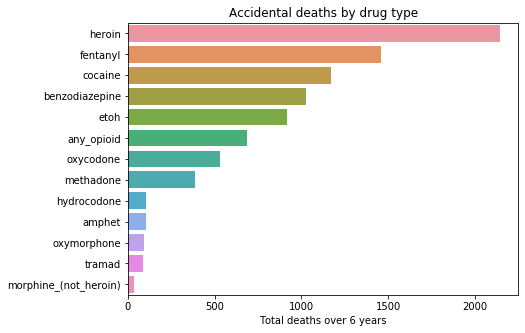

In [12]:
deaths_by_drug = df[drug_types].sum().sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=[7, 5])
sns.barplot(x=deaths_by_drug, y=deaths_by_drug.index)
ax.set_xlabel('Total deaths over 6 years')
ax.set_title('Accidental deaths by drug type')
plt.show()

Death tend.


In [13]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['year'] = df['date'].dt.year
df['year_month'] = df['date'].dt.to_period('M')
df['year_month']

0       2013-11
1       2012-12
2       2014-02
3       2014-09
4       2013-10
         ...   
4076    2017-07
4077    2017-08
4078    2017-07
4079    2017-11
4080    2017-12
Name: year_month, Length: 4081, dtype: period[M]

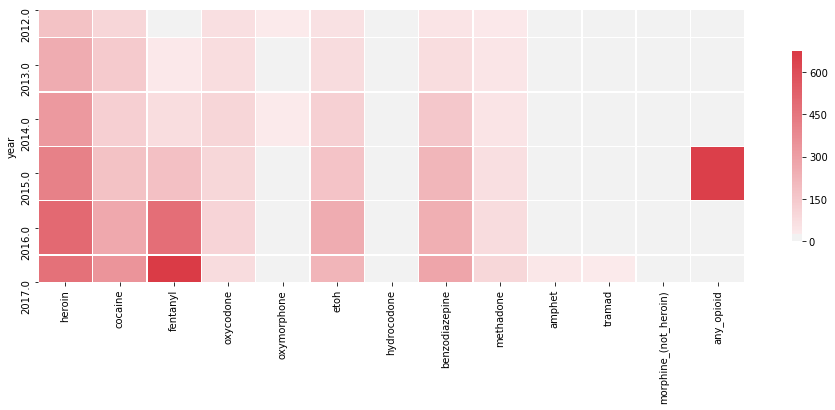

In [15]:
time_trends_by_drug = df.groupby(by=['year'])[drug_types].sum()

#TODO ROTATE PLOT
fig, ax = plt.subplots(1, 1, figsize=[17, 5])
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data=time_trends_by_drug, square=True, cmap=cmap, center=0,
            linewidths=.5, cbar_kws={"shrink": .7}, ax=ax)
plt.show()

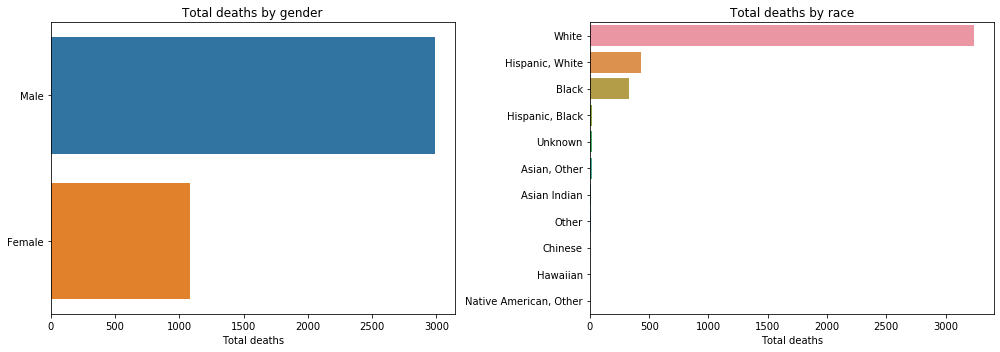

In [16]:
gender_counts = df['sex'].value_counts()
race_counts = df['race'].value_counts()
fig, (ax, ax1) = plt.subplots(1, 2, figsize=[14, 5])
sns.barplot(x=gender_counts, y=gender_counts.index, ax=ax)
sns.barplot(x=race_counts, y=race_counts.index, ax=ax1)
ax.set_title('Total deaths by gender')
ax.set_xlabel('Total deaths')
ax1.set_title('Total deaths by race')
ax1.set_xlabel('Total deaths')
plt.tight_layout()
plt.show()

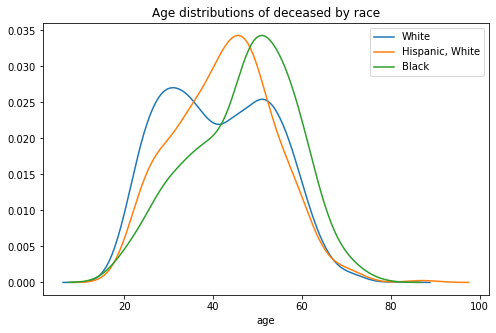

In [17]:
fig, ax = plt.subplots(1, 1, figsize=[8, 5])
for race in df['race'].unique():
    if sum(df['race'] == race) > 100:
        sns.distplot(df.loc[df['race'] == race, 'age'], hist=False, label=race, ax=ax)
ax.set_title('Age distributions of deceased by race')
ax.autoscale()
ax.legend()
plt.show()

In [18]:
deaths_by_gender = deaths_by_drug.copy()
for gender in ['Male', 'Female']:
    temp_gender_df = df.loc[df['sex'] == gender, drug_types].sum().sort_values(ascending=False)
    temp_gender_df = 100 * temp_gender_df / sum(temp_gender_df)  # Change to a percentage
    deaths_by_gender = pd.DataFrame(deaths_by_gender).join(pd.DataFrame(temp_gender_df), rsuffix=gender)

In [19]:
deaths_by_race = deaths_by_drug.copy()
for race in ['White', 'Hispanic, White', 'Black']:
    temp_race_df = df.loc[df['race'] == race, drug_types].sum().sort_values(ascending=False)
    temp_race_df = 100 * temp_race_df / sum(temp_race_df)  # Change to a percentage
    deaths_by_race = pd.DataFrame(deaths_by_race).join(pd.DataFrame(temp_race_df), rsuffix=race)

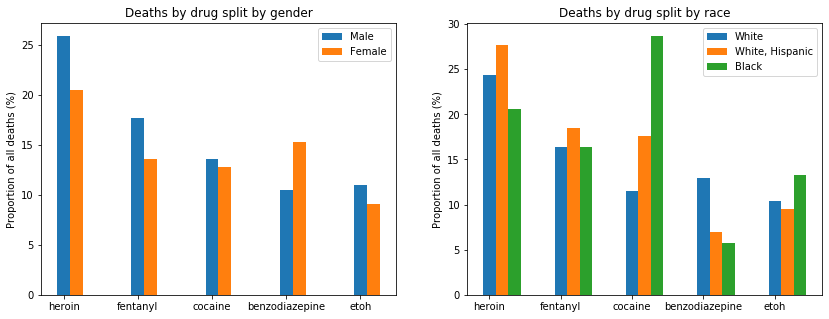

In [20]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(14, 5))

N = len(deaths_by_gender.index[:5])
ind = np.arange(N)
width = 0.35
ax.bar(x=ind, 
       height=deaths_by_gender.iloc[:5, 1].values, 
       width=width/2, 
       label='Male')
ax.bar(x=ind + width/2, 
       height=deaths_by_gender.iloc[:5, 2].values, 
       width=width/2, 
       label='Female')
ax.set_xticks(ind)
ax.set_xticklabels(deaths_by_gender.index[:5])
ax.set_ylabel('Proportion of all deaths (%)')
ax.set_title('Deaths by drug split by gender')
ax.legend()

ax1.bar(x=ind, 
       height=deaths_by_race.iloc[:5, 1].values, 
       width=width/2, 
       label='White')
ax1.bar(x=ind + width/2, 
       height=deaths_by_race.iloc[:5, 2].values, 
       width=width/2, 
       label='White, Hispanic')
ax1.bar(x=ind + width, 
       height=deaths_by_race.iloc[:5, 3].values, 
       width=width/2, 
       label='Black')
ax1.set_xticks(ind)
ax1.set_xticklabels(deaths_by_race.index[:5])
ax1.set_ylabel('Proportion of all deaths (%)')
ax1.set_title('Deaths by drug split by race')
ax1.legend()


plt.show()